## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn import preprocessing

% matplotlib inline

## Import Data

In [2]:
df = pd.read_csv('./bank-additional/bank-additional-full.csv',delimiter=';')
len(df)

41188

Let us see the data-types

In [3]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

### Classifiying the columns with data-types -
#### 1.Numerical Data
#### 2. Categorical Data
##### a) Two Categories (default, housing, loan)
    Can be encoded by mapping 0 and 1 directly
##### b) Multiple Categories - no hierarcy (job, marital, contact, month, day_of_week, poutcome)
    Can be encoded by create a separate column for each category
##### c) Multiple Categories - hierarcy (education)
    Can be encoded by assigning levels in a single category (0,1,2,etc)

In [4]:
numeric = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 
           'euribor3m', 'nr.employed',]
binary = ['default', 'housing', 'loan']
categorical = ['poutcome', 'job', 'marital', 'contact', 'month','day_of_week']
hierarchy = ['education']

## Unknowns - dealing with null values

To start with let's calculate how much is 1% of the data. If a column contains null values less than that, we'll simply delete those rows.

In [5]:
#Calculating 1% of the total data
print ("1% of the total data means " + str(round(0.01 * len(df))) + " out of " + str(len(df)) + ".")

1% of the total data means 412 out of 41188.


### Deleting smaller unknowns

<pre><code>for i in binary+categorical+hierarchy:
    print(df[i].value_counts())</code></pre>
    
It was observed from this code that there are unknown values in the categorical columns, which is essentially null values. Let us only entertain the unknowns if the total number unknowns is more than 1% of that data (round that up to 500)

In [6]:
null_cols = []
for column in binary+categorical+hierarchy:
    #Delete few unknowns
    if len(df.loc[df[column] == 'unknown']['y']) < 500:
        df = df[df[column] != 'unknown']
    elif len(df.loc[df[column] == 'unknown']['y']) > 500:
        #Find which columns have still retained unkowns
        print("Column {} - still contains unknowns".format(column))
        null_cols.append(column)

Column default - still contains unknowns
Column housing - still contains unknowns
Column loan - still contains unknowns
Column education - still contains unknowns


### Encoding categorical variables
#### 1. Binary

In [7]:
def binary_encoding(df,binary=binary): # Map 0 and 1
    for column in binary: 
        df[column] = df[column].map({'yes':1,'no':0}) #Warning: This changes 'unknown' into NaN
    return df
df = binary_encoding(df)
df[binary].head()

,default,housing,loan
0,0.0,0.0,0.0
1,NaN,0.0,0.0
2,0.0,1.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,1.0


#### 2. Hierarchical

In [8]:
""" This is specific for education. We need a manually created hierarcy as an input here."""
values = ["illiterate", "basic.4y", "basic.6y", "basic.9y", "high.school",  "professional.course", "university.degree"]
levels = range(1,len(values)+1)
dictionary = dict(zip(values,levels))
df['education']=df['education'].map(dictionary)
df['education'] = df['education'].replace('unknown', np.nan, regex=True)
#df['education']

#### 3. Categorical

In [9]:
def categorical_encoding(df,categorical=categorical):
    for column in categorical:
        
        dummies = pd.get_dummies(df[column])
        dummies = dummies.rename(columns = lambda x: column + '_' + str(x))
        
        df = pd.concat([df,dummies],axis=1)
        df = df.drop(column,axis=1)
    return df

df = categorical_encoding(df)
#list(df.columns)

### Investigate for null values in numerical columns

In [10]:
print ("Null Values - ")
for column in numeric:
    null = sum(df[column].isnull())
    print (" {} - {}".format(column, str(null)))
    if null > 0:
        null_cols.append(column)

Null Values - 
 age - 0
 duration - 0
 campaign - 0
 pdays - 0
 previous - 0
 emp.var.rate - 0
 cons.price.idx - 0
 cons.conf.idx - 0
 euribor3m - 0
 nr.employed - 0


Now, we can move forward and predict the missing data using random forest. But before doing that, let's scale the numerical data first so that our random forest predictions are more accurate as well.

## Scaling

In [11]:
scaler = preprocessing.StandardScaler()
df[numeric] = scaler.fit_transform(df[numeric])

### Use random forest to fill null values in default, housing, loan and education

Before we start this process. We have to encode y as well.

In [12]:
#encoding y
df['y'] = df['y'].map({'yes':1,'no':0})

In [13]:
def predict_unknown(trainX, trainY, testX):
    """ Predicting unknown data using random forest"""
    forest = RandomForestClassifier(n_estimators=100)
    forest = forest.fit(trainX, trainY)
    test_predictY = forest.predict(testX).astype(int)
    return pd.DataFrame(test_predictY,index=testX.index)

In [14]:
print(null_cols)

['default', 'housing', 'loan', 'education']


In [15]:
#test_data = df[df['default'].isnull()]
#test_data

In [16]:
for column in null_cols:
    test_data = df[df[column].isnull()]
    testX = test_data.drop(null_cols, axis=1)
    train_data = df[df[column].notnull()]        
    trainY = train_data[column]
    trainX = train_data.drop(null_cols, axis=1)
    #print(trainX.isnull().sum())
    #print(trainY.value_counts())
    test_data[column] = predict_unknown(trainX, trainY, testX)
    df = pd.concat([train_data, test_data])

C:\Users\labuser\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\labuser\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\labuser\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

In [17]:
print ("Null Values - \n")
for column in list(df.columns):
    null = sum(df[column].isnull())
    print (" {} - {}".format(column, str(null)))

Null Values - 

 age - 0
 education - 0
 default - 0
 housing - 0
 loan - 0
 duration - 0
 campaign - 0
 pdays - 0
 previous - 0
 emp.var.rate - 0
 cons.price.idx - 0
 cons.conf.idx - 0
 euribor3m - 0
 nr.employed - 0
 y - 0
 poutcome_failure - 0
 poutcome_nonexistent - 0
 poutcome_success - 0
 job_admin. - 0
 job_blue-collar - 0
 job_entrepreneur - 0
 job_housemaid - 0
 job_management - 0
 job_retired - 0
 job_self-employed - 0
 job_services - 0
 job_student - 0
 job_technician - 0
 job_unemployed - 0
 marital_divorced - 0
 marital_married - 0
 marital_single - 0
 contact_cellular - 0
 contact_telephone - 0
 month_apr - 0
 month_aug - 0
 month_dec - 0
 month_jul - 0
 month_jun - 0
 month_mar - 0
 month_may - 0
 month_nov - 0
 month_oct - 0
 month_sep - 0
 day_of_week_fri - 0
 day_of_week_mon - 0
 day_of_week_thu - 0
 day_of_week_tue - 0
 day_of_week_wed - 0


## Here's is how features looks like -

In [18]:
df.head()

,age,education,default,housing,loan,duration,campaign,pdays,previous,emp.var.rate,...,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,1.540198,2.0,0.0,0.0,0.0,0.010299,-0.565778,0.19472,-0.349341,0.649306,...,0,1,0,0,0,0,1,0,0,0
2,-0.286369,5.0,0.0,1.0,0.0,-0.124697,-0.565778,0.19472,-0.349341,0.649306,...,0,1,0,0,0,0,1,0,0,0
3,0.002036,3.0,0.0,0.0,0.0,-0.413975,-0.565778,0.19472,-0.349341,0.649306,...,0,1,0,0,0,0,1,0,0,0
4,1.540198,5.0,0.0,0.0,1.0,0.187723,-0.565778,0.19472,-0.349341,0.649306,...,0,1,0,0,0,0,1,0,0,0
6,1.828603,6.0,0.0,0.0,0.0,-0.460259,-0.565778,0.19472,-0.349341,0.649306,...,0,1,0,0,0,0,1,0,0,0


## Prediction

### Random Forest

Let's try random forest. I'd like to start with random forest because I will like to see how different features stack up using feature importances.

In [19]:
#Let's take all the features in for prediction
predictors = list(df.drop('y',axis=1).columns)

#### Some Random Forest Parameters
** 1. n_estimators - ** The number of trees in the forest

** 1. gini - ** The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and
                “entropy” for the information gain. Note: this parameter is tree-specific.
                
** 1. max_features - ** The number of features to consider when looking for the best split

** 1. max_features - ** The number of features to consider when looking for the best split

** 1. min_samples_leaf - ** The number of trees in the forest

** 1. n_estimators - ** The number of trees in the forest

In [20]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import ShuffleSplit


import numpy as np

# Initialize our algorithm with the default paramters
# n_estimators is the number of trees we want to make
# min_samples_split is the minimum number of rows we need to make a split
# min_samples_leaf is the minimum number of samples we can have at the place where a tree branch ends (the bottom points of the tree)
rf = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=10, 
                            min_samples_leaf=10)
kf = KFold(df.shape[0], n_folds=5, random_state=1)
cv = ShuffleSplit(n_splits=50, test_size=0.3, random_state=50)

predictions = cross_validation.cross_val_predict(rf, df[predictors],df["y"],cv=kf)
predictions = pd.Series(predictions)
scores = cross_val_score(rf, df[predictors], df["y"],
                                          scoring='f1', cv=kf)
# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

C:\Users\labuser\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


0.274189923504


I want to swing different parameters to see how accuracy changes

**1. n_estimators**

In [28]:
predictors = list(df.drop('y',axis=1).columns)

kf = KFold(df.shape[0], n_folds=5, random_state=1)
cv = ShuffleSplit(n_splits=50, test_size=0.3, random_state=50)
scorelist = []
r = list(range(1,25,2))

for i in r:
    
    rf = RandomForestClassifier(random_state=1, n_estimators=i, min_samples_split=10, 
                            min_samples_leaf=10)
    
    predictions = cross_validation.cross_val_predict(rf, df[predictors],df["y"],cv=kf)
    predictions = pd.Series(predictions)
    scores = cross_val_score(rf, df[predictors], df["y"], scoring='f1', cv=kf)
    scorelist.append(scores.mean())

C:\Users\labuser\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


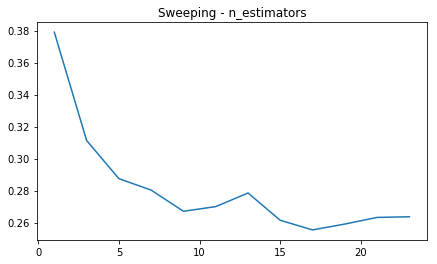

In [29]:
#Plotting
plt.figure(figsize=(7,4))
plt.title("Sweeping - n_estimators")
plt.plot(r,scorelist)

**2. min_samples_split**

In [40]:
predictors = list(df.drop('y',axis=1).columns)

kf = KFold(df.shape[0], n_folds=5, random_state=1)
cv = ShuffleSplit(n_splits=50, test_size=0.3, random_state=50)
scorelist = []
r = list(range(60,65,1))

for i in r:
    
    rf = RandomForestClassifier(random_state=1, n_estimators=100, min_samples_split=i, 
                            min_samples_leaf=10)
    
    predictions = cross_validation.cross_val_predict(rf, df[predictors],df["y"],cv=kf)
    predictions = pd.Series(predictions)
    scores = cross_val_score(rf, df[predictors], df["y"], scoring='f1', cv=kf)
    scorelist.append(scores.mean())

C:\Users\labuser\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\labuser\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\labuser\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\labuser\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


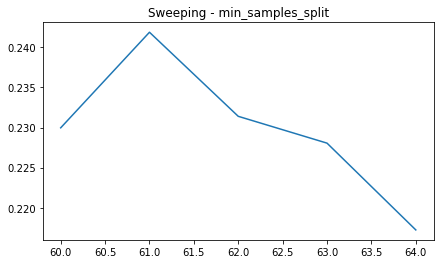

In [41]:
#Plotting
plt.figure(figsize=(7,4))
plt.title("Sweeping - min_samples_split")
plt.plot(r,scorelist)

In [42]:
#Plotting
#plt.figure(figsize=(7,4))
#plt.title("Sweeping - min_samples_split")
#plt.plot(r,scorelist)

**2. min_samples_leaf**

In [43]:
predictors = list(df.drop('y',axis=1).columns)

kf = KFold(df.shape[0], n_folds=5, random_state=1)
cv = ShuffleSplit(n_splits=50, test_size=0.3, random_state=50)
scorelist = []
r = list(range(2,500,10))

for i in r:
    
    rf = RandomForestClassifier(random_state=1, n_estimators=100, min_samples_split=62, 
                            min_samples_leaf=i)
    
    predictions = cross_validation.cross_val_predict(rf, df[predictors],df["y"],cv=kf)
    predictions = pd.Series(predictions)
    scores = cross_val_score(rf, df[predictors], df["y"], scoring='f1', cv=kf)
    scorelist.append(scores.mean())

C:\Users\labuser\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\labuser\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\labuser\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\labuser\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\labuser\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113:

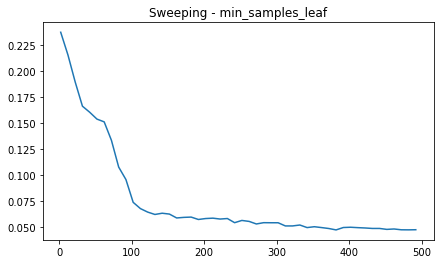

In [44]:
#Plotting
plt.figure(figsize=(7,4))
plt.title("Sweeping - min_samples_leaf")
plt.plot(r,scorelist)

##### Different Parameters

In [46]:
rf = RandomForestClassifier(random_state=1, n_estimators=100,min_samples_leaf=2)
rf.fit(df[predictors],df["y"])
kf = KFold(df.shape[0], n_folds=5, random_state=1)
predictions = cross_validation.cross_val_predict(rf, df[predictors],df["y"],cv=kf)
predictions = pd.Series(predictions)
scores = cross_val_score(rf, df[predictors], df["y"],scoring='f1', cv=kf)
# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.358695810093


### Important Features

['duration', 'euribor3m', 'age', 'nr.employed', 'pdays']


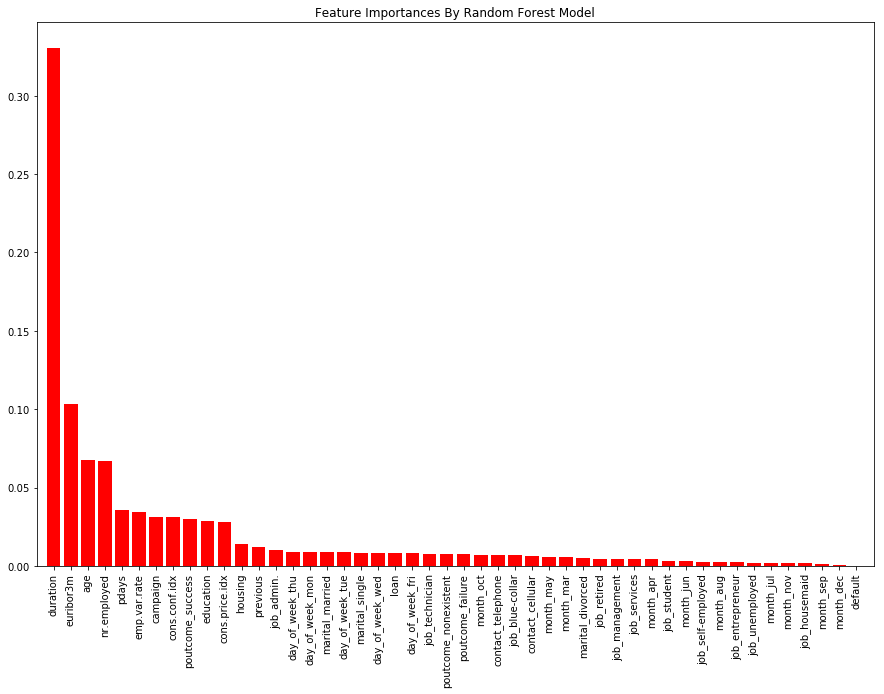

In [47]:
importances=rf.feature_importances_
std = np.std([rf.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
sorted_important_features=[]
for i in indices:
    sorted_important_features.append(predictors[i])
#predictors=titanic.columns
plt.figure(figsize=(15,10))
plt.title("Feature Importances By Random Forest Model")
plt.bar(range(np.size(predictors)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(np.size(predictors)), sorted_important_features, rotation='vertical')

plt.xlim([-1, np.size(predictors)])
print(sorted_important_features[0:5])

Let's try by only selecting the top features until housing. Same parameters.

In [48]:
predictors = sorted_important_features[0:12]

rf = RandomForestClassifier(random_state=1, n_estimators=100)
rf.fit(df[predictors],df["y"])
kf = KFold(df.shape[0], n_folds=5, random_state=1)
predictions = cross_validation.cross_val_predict(rf, df[predictors],df["y"],cv=kf)
predictions = pd.Series(predictions)
scores = cross_val_score(rf, df[predictors], df["y"],scoring='f1', cv=kf)
# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.44232881872


In [27]:
len(df)*0.01

407.87